# CASE STUDY - topic modeling and feature engineering


[Feature engineering](https://en.wikipedia.org/wiki/Feature_engineering) is the process of using domain knowledge of your data to create features that can be leveraged by machine learning.  That is not a hard definition, because sometimes it is used in a context where features are transformed for machine learning, but the inclusion of domain knowledge is not implied.  

It is unfortunately common that for large datasets engineered features are not easy to create.  When there are many features generally only a small number play an important roll when it comes to prediction.  Furthermore,  domain insight is even more difficult to fold into the model when there are hundreds or thousands of features to keep in mind.  However, there is a middle ground---much of the worlds knowledge is locked up in language.  In this case study we will use topic modeling to gather insight from text.  Ideally, the result of these types of experiments would be shared with domain experts to further engineer features that are relevant when it comes to your business opportunity.

In [1]:
import os
import re
import sys
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from string import punctuation, printable
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

try:
    import pyLDAvis
    import pyLDAvis.sklearn
except:
    raise Exception("'pip install pyldavis' before running this notebook")

pyLDAvis.enable_notebook()    
plt.style.use('seaborn')
%matplotlib inline

## supress all warnings (not to be used during development)
import warnings
warnings.filterwarnings("ignore")

C:\Source-Files\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


## Synopsis

   >Goal:  AAVAIL has recently enabled comments on the core streaming service.  The data science team knows that   this will be an incredibly important source of data going forward.  It will be used inform customer retention, product quality, product market fit and more.  Comments are going live next week and being the diligent data scientist that you are your plan is to build a topic modeling pipeline that that will consume the comments and create visualizations that can be used to communicate with domain experts.
  
## Outline

1. EDA - summary tables, use tSNE to visualize the data
2. Create a transfomation pipelines for NMF and LDA
3. Use ldaviz and wordclouds to get insight into the clusters

## Data

Here we see how to load the data.

* [download the movie review data](http://www.nltk.org/nltk_data)
* For more examples of applications with these data see [NLTK's book chapter that uses these data](https://www.nltk.org/book/ch06.html)

In [2]:
data_dir = os.path.join(".")
movie_reviews = load_files(os.path.join(data_dir,"movie_reviews"), shuffle=True)
X = movie_reviews.data
y = movie_reviews.target
target_names = movie_reviews.target_names
print(X[0])

b"arnold schwarzenegger has been an icon for action enthusiasts , since the late 80's , but lately his films have been very sloppy and the one-liners are getting worse . \nit's hard seeing arnold as mr . freeze in batman and robin , especially when he says tons of ice jokes , but hey he got 15 million , what's it matter to him ? \nonce again arnold has signed to do another expensive blockbuster , that can't compare with the likes of the terminator series , true lies and even eraser . \nin this so called dark thriller , the devil ( gabriel byrne ) has come upon earth , to impregnate a woman ( robin tunney ) which happens every 1000 years , and basically destroy the world , but apparently god has chosen one man , and that one man is jericho cane ( arnold himself ) . \nwith the help of a trusty sidekick ( kevin pollack ) , they will stop at nothing to let the devil take over the world ! \nparts of this are actually so absurd , that they would fit right in with dogma . \nyes , the film is 

### QUESTION 1

The main focus of this exercise is to enable visualization of topics, but these topics can be used as additional 
features for prediction tasks.  The goal of this case study is to ensure that you are comfortable with natural language processing pipelines and topic modeling tools. 

There are many ways to process tokens (words, dates, emojis etc).  NLTK is often used to pre-process text data before the tokens are vectorized.  Generally, the tokens are modified via [stemming or lemmatization](https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html).  The next code block provides a lemmatization function that makes use of the library [spacy](https://spacy.io/).  You will need to install it and download the English language reference material as follows.  Stopwords are words that are very common or otherwise irrelevant we use a default list here, but it is an important part of NLP pipelines that needs to be customized for the subject area. Use the following function to process the corpus (this can take a few minutes)

```bash
~$ pip install spacy
~$ python -m spacy download en
```

If you prefer to use NLTK then you could use a simple lemmatizer like the WordLemmatizer.

In [3]:
import spacy
STOPLIST = ENGLISH_STOP_WORDS
STOPLIST = set(list(STOPLIST) + ["foo"])

if not 'nlp' in locals():
    print("Loading English Module...")
    nlp = spacy.load('en')

def lemmatize_document(doc, stop_words=None):
    """
    takes a list of strings where each string is a document
    returns a processed list of strings
    """
    
    if not stop_words:
        stop_words = set([])
  
    ## ensure working with string
    doc = str(doc)

    # First remove punctuation form string
    if sys.version_info.major == 3:
        PUNCT_DICT = {ord(punc): None for punc in punctuation}
        doc = doc.translate(PUNCT_DICT)

    # remove unicode
    clean_doc = "".join([char for char in doc if char in printable])
            
    # Run the doc through spaCy
    doc = nlp(clean_doc)

    # Lemmatize and lower text
    tokens = [re.sub("\W+","",token.lemma_.lower()) for token in doc ]
    tokens = [t for t in tokens if len(t) > 1]
    
    return ' '.join(w for w in tokens if w not in stop_words)    

## example usage
corpus = ['"You can fool some of the people all of the time, and all of the people some of the time, but you can not fool all of the people all of the time". -- Abraham Lincoln']
processed = [lemmatize_document(doc, STOPLIST) for doc in corpus]
print(processed[0])
processed = [lemmatize_document(doc, None) for doc in corpus]
print("\n"+processed[0])

Loading English Module...
pron fool people time people time pron fool people time abraham lincoln

pron can fool some of the people all of the time and all of the people some of the time but pron can not fool all of the people all of the time abraham lincoln


In [4]:
## Use stemming or lemmatization to process the corpus
## YOUR CODE HERE
processed = [lemmatize_document(doc, STOPLIST) for doc in X]
print("processing done.")

processing done.


### QUESTION 2

Use the CountVectorizer from sklearn to vectorize the tokens.

Additional resources:

* [scikit-learn CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)
* [scikit-learn working with text](https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html)

Because this is an exercise in visualization set the `max_features` to something like 1000.  In the context of supervised learning it is reasonable to grid-search to optimize this parameter.

In [5]:
## YOUR CODE HERE

max_features = 1000
tf_vectorizer = CountVectorizer(max_df=0.95, 
                                min_df=2,
                                max_features=max_features,
                                stop_words='english')
tf = tf_vectorizer.fit_transform(processed)
print("ready")

ready


### QUESTION 3

Use model the corpus with LDA.  For example, you could use something like the following.

```python
n_topics = 10
lda_model = LatentDirichletAllocation(n_components=n_topics, max_iter=5,
                                      learning_method='online',
                                      learning_offset=50.,
                                      random_state=0)

lda_model.fit(tf)
```

You could use a pipeline here to make it easier to iterate on changes.

* [scikit-learn's LDA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html)
* [scikit-learn's user guide for LDA](https://scikit-learn.org/stable/modules/decomposition.html#latentdirichletallocation)

In [6]:
## YOUR CODE HERE
n_topics = 10
lda_model = LatentDirichletAllocation(n_components=n_topics, max_iter=5,
                                      learning_method='online',
                                      learning_offset=50.,
                                      random_state=0)
lda_model.fit(tf)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=50.0,
                          max_doc_update_iter=100, max_iter=5,
                          mean_change_tol=0.001, n_components=10, n_jobs=None,
                          perp_tol=0.1, random_state=0, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

## QUESTION 4

Visualize the corpus using [pyldavis](https://github.com/bmabey/pyLDAvis).

```python
pyLDAvis.sklearn.prepare(lda_model,tf, tf_vectorizer, R=20)
```

* [PyLDAViz documentation](https://pyldavis.readthedocs.io/en/latest)
* [PyLDAViz demos](https://pyldavis.readthedocs.io/en/latest/readme.html#video-demos)

In [7]:
## YOUR CODE HERE

pyLDAvis.sklearn.prepare(lda_model,tf, tf_vectorizer, R=20)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.003008 -0.005134       1        1  38.006099
8     -0.020065 -0.031353       2        1  35.121996
1     -0.005264 -0.034874       3        1  10.571538
5     -0.032837 -0.065788       4        1   6.595433
4     -0.024275 -0.100184       5        1   4.071189
0     -0.009535 -0.047388       6        1   3.930127
2     -0.122270  0.254781       7        1   0.699978
3      0.299756  0.076939       8        1   0.553726
9     -0.068372 -0.028629       9        1   0.395355
6     -0.014129 -0.018372      10        1   0.054558, topic_info=          Term          Freq         Total Category  logprob  loglift
321       film  10959.000000  10959.000000  Default  20.0000  20.0000
603       nthe   7796.000000   7796.000000  Default  19.0000  19.0000
838       star   1209.000000   1209.000000  Default  18.0000  18.0000
537      movie   6628.000000   6628.000000  Default  17.0000  17.0000
10      action   1146.000000   1146.000000  Default  16.0000  16.0000
..         ...           ...           ...      ...      ...      ...
484       look      0.330704   1727.428810  Topic10  -6.3980  -1.0473
137  character      0.362509   3809.801287  Topic10  -6.3062  -1.7464
606     nthere      0.306086   1231.813527  Topic10  -6.4754  -0.7865
493       make      0.328343   4073.737712  Topic10  -6.4052  -1.9124
495        man      0.308548   1827.670376  Topic10  -6.4674  -1.1730

[394 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
7         1  0.123301  accident
7         2  0.369902  accident
7         3  0.016440  accident
7         4  0.032880  accident
7         5  0.402783  accident
...     ...       ...       ...
996       5  0.034876      year
996       6  0.025189      year
996       7  0.000646      year
996       8  0.002583      year
996       9  0.001292      year

[1847 rows x 3 columns], R=20, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 9, 2, 6, 5, 1, 3, 4, 10, 7])

## QUESTION 5

Try different numbers of clusters until there is decent separation in the visualization

In [8]:
## YOUR CODE HERE

max_features = 1000
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=max_features,
                                stop_words='english')
n_topics = 30
lda_model = LatentDirichletAllocation(n_components=n_topics, max_iter=5,
                                      learning_method='online',
                                      learning_offset=50.,
                                      random_state=0)

pipe = Pipeline([('tf', tf_vectorizer),
                 ('lda',lda_model)])

lda_transformed = pipe.fit_transform(processed)
tf = tf_vectorizer.fit_transform(processed)
pyLDAvis.sklearn.prepare(pipe['lda'], tf, pipe['tf'], R=20)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8     -0.038424  0.030784       1        1  27.132872
7     -0.041482  0.032572       2        1  26.620364
11    -0.031120 -0.000599       3        1  14.728496
28    -0.054247  0.041130       4        1  12.139482
18    -0.091209  0.036278       5        1  10.986898
14    -0.069744  0.001491       6        1   2.060696
17    -0.060722  0.047711       7        1   1.953649
5     -0.072418  0.046013       8        1   1.187813
0     -0.019966  0.063210       9        1   0.983667
3      0.259555 -0.118632      10        1   0.594061
10     0.262685  0.234809      11        1   0.305180
21     0.115121 -0.007574      12        1   0.279546
9      0.120958  0.145039      13        1   0.177369
4     -0.044334 -0.013830      14        1   0.158978
26     0.135007 -0.269127      15        1   0.157772
19     0.017449 -0.081027      16        1   0.152908
15    -0.056282 -0.019868      17        1   0.064671
16    -0.031949 -0.018853      18        1   0.057851
20    -0.007793 -0.027923      19        1   0.057680
1     -0.025032 -0.001262      20        1   0.018186
25    -0.025889 -0.007428      21        1   0.018186
2     -0.023306 -0.002077      22        1   0.018186
29    -0.025765 -0.009991      23        1   0.018186
23    -0.026438 -0.008659      24        1   0.018186
13    -0.028176 -0.012657      25        1   0.018186
27    -0.028666 -0.015764      26        1   0.018186
24    -0.026915 -0.016093      27        1   0.018186
12    -0.027402 -0.017243      28        1   0.018186
6     -0.027382 -0.015208      29        1   0.018186
22    -0.026111 -0.015220      30        1   0.018186, topic_info=       Term          Freq         Total Category  logprob  loglift
321    film  10773.000000  10773.000000  Default  20.0000  20.0000
603    nthe   7745.000000   7745.000000  Default  19.0000  19.0000
537   movie   6748.000000   6748.000000  Default  18.0000  18.0000
474    life   1660.000000   1660.000000  Default  17.0000  17.0000
493    make   4062.000000   4062.000000  Default  16.0000  16.0000
..      ...           ...           ...      ...      ...      ...
321    film      0.105272  10773.912145  Topic30  -6.4441  -2.9238
566     nhe      0.091312   1637.027022  Topic30  -6.5864  -1.1818
357    good      0.092491   3330.327829  Topic30  -6.5735  -1.8792
164  comedy      0.087180    892.321662  Topic30  -6.6327  -0.6213
484    look      0.087972   1732.320748  Topic30  -6.6236  -1.2757

[1147 rows x 6 columns], token_table=      Topic      Freq Term
term                      
0         1  0.184154   10
0         2  0.256500   10
0         3  0.111808   10
0         4  0.072346   10
0         5  0.151269   10
...     ...       ...  ...
997       5  0.083571  yes
997       6  0.006964  yes
997       7  0.020893  yes
997       8  0.006964  yes
997      12  0.041786  yes

[4672 rows x 3 columns], R=20, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 8, 12, 29, 19, 15, 18, 6, 1, 4, 11, 22, 10, 5, 27, 20, 16, 17, 21, 2, 26, 3, 30, 24, 14, 28, 25, 13, 7, 23])

The visualization here can help determine a reasonable number of number of clusters and it can serve as a communication tool.  If the goal was to find topics that are associated with customer profiles then you would likely work with folks in marketing to refine the clustering.  There are a couple of parameters than can be used to modify the clustering and visualization.  The discovery of meaningful topics is a form of feature engineering.

## QUESTION 6

If you were to use the topics from this model to inform clustering or supervised learning you would first need to be able to extract and represent them as a matrix.  Along the same lines if you were to populate a report with tabular descriptions of the data then you will need to be able to extract topic representations.  Here is a starter function

```python
def get_top_words(model, feature_names, n_top_words):
    top_words = {}
    for topic_idx, topic in enumerate(model.components_):
        _top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        top_words[str(topic_idx)] = _top_words
    return(top_words)
```

Use the function to print the top k words for each topic

In [9]:
## YOUR CODE HERE

def get_top_words(model, feature_names, n_top_words):
    top_words = {}
    for topic_idx, topic in enumerate(model.components_):
        _top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        top_words[str(topic_idx)] = _top_words
    return(top_words)

## create a matrix of the top words used to define each topic
top_words = 15
tf_feature_names = np.array(tf_vectorizer.get_feature_names())
top_words = get_top_words(lda_model,tf_feature_names,top_words)
all_top_words = np.array(list(set().union(*[v for v in top_words.values()])))

for key,vals in top_words.items():
    print(key," ".join(vals))
print("total words: %s"%len(all_top_words))

0 war ryan soldier film nthe private battle bond movie army tom save man action world
1 film nthe make character choice scene david life like good cop nit story thing movie
2 film movie provide time girl town make amusing scene nthe know eddie hard wrong plot
3 star series trek alien television fan generation episode planet menace film race crew cast space
4 truman jim world camera perfect life nhis television nthe doubt wife concept film town light
5 vampire wedding dog titanic cameron love nthe film singer play rise friend dance movie life
6 film love beautiful nhe nthe movie performance end family manage strong memorable son plot time
7 movie nthe film like just make bad good ni nit time character know really think
8 film nthe good make character like scene movie play time nit just great work performance
9 rush chan hour lee mr guy chris film carter involve action american nice case nthe
10 jackie chan brown fight art master fiction mr style film action ii release early kiss
11 film

## QUESTION (EXTRA CREDIT) 7

If you used `fit_transform` on your original tokens you should have a `2000 x k` array where `k` is the number of topics you choose.  Create a PCA or tSNE visualization that projects the tf matrix into lower dimensional space then uses colors to indicate which documents belong to a topic (e.g. probability > 0.5).

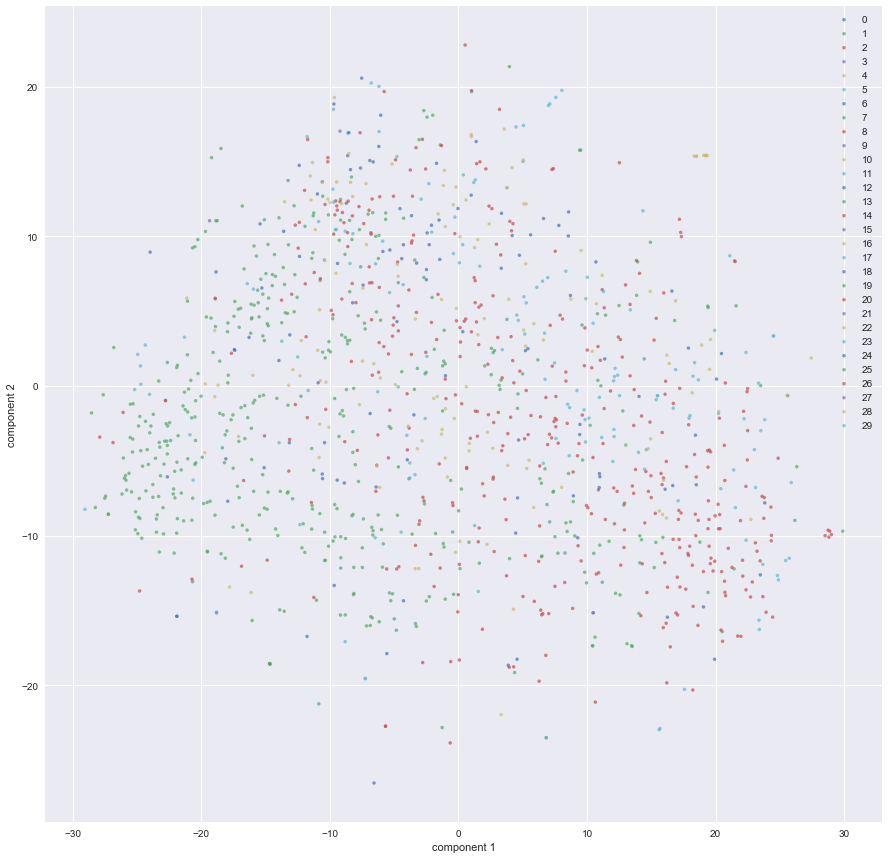

In [10]:
## YOUR CODE HERE

def make_tsne_plot(tf,lda_mat):
    
    fig = plt.figure(figsize=(15,15),facecolor='white')
    colors = np.array(['red','yellow','cyan','orange','black','grey','green','royalblue'])
    ax = fig.add_subplot(111)
    
    pca = PCA(50)
    pca_projected = pca.fit_transform(tf.todense(),2)
    
    tsne = TSNE(n_components=2,perplexity=50.0,init='pca')
    tsne_projected = tsne.fit_transform(pca_projected)
    
    for class_num in np.arange(n_topics):
        topic_inds = np.where(lda_mat[:,class_num] > 0.5)[0]
        ax.scatter(tsne_projected[topic_inds, 0],
                   tsne_projected[topic_inds, 1], 
                   edgecolor='none', marker='.', alpha=0.7, label=str(class_num))

    ax.set_xlabel('component 1')
    ax.set_ylabel('component 2')
    ax.legend();
 
make_tsne_plot(tf,lda_transformed)

<iframe src="https://player.vimeo.com/video/87110435" width="640" height="360"  frameborder="0" allowfullscreen></iframe>